<a href="https://colab.research.google.com/github/karencfisher/COVID19/blob/main/covidradio_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
!unzip -q /content/drive/MyDrive/COVID-19_Radiography_Dataset/data.zip

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint




#### Get metadata on training set 

In [ ]:
classes = ('normal', 'COVID')
data_path = 'data'

counts = []
filelists = []
for item in classes:
    filelist = os.listdir(os.path.join(data_path, 'train', item))
    filelists.append(filelist)
    counts.append(len(filelist))


#### Visualize samples of the image data by class

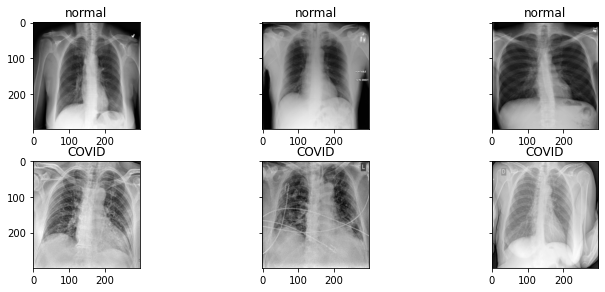

In [ ]:
f, axes = plt.subplots(len(classes), 3, sharey=True)
f.set_figwidth(10)
plt.tight_layout()

for i, item in enumerate(classes):
    images = random.sample(filelists[i], 3)
    for j, image in enumerate(images):
        img_file = os.path.join(data_path, 'train', item, image)
        img = plt.imread(img_file)
        axes[i][j].imshow(img, cmap='gray')
        axes[i][j].set_title(item)


#### Plot prevalence of classes

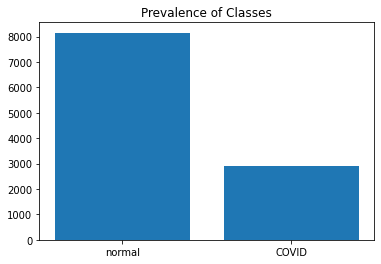

In [ ]:
plt.bar(classes, counts)
plt.title('Prevalence of Classes');

#### Preprocessing step to enhance the images
CLAHE (Contrast Limited Adaptive Histogram Equalization)

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def preprocess(img):
  img_gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img_gs = img_gs.astype(np.uint16)
  img_clahe = clahe.apply(img_gs)
  img_clahe = img_clahe.astype(np.float32)
  img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)
  return img_clahe / 255

#### Data generators to import images into the classifier

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess)

train_path = os.path.join(data_path, 'train')
train_gen = datagen.flow_from_directory(directory=train_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

valid_path = os.path.join(data_path, 'validation')
valid_gen = datagen.flow_from_directory(directory=valid_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

test_path = os.path.join(data_path, 'test')
test_gen = datagen.flow_from_directory(directory=test_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

Found 11045 images belonging to 2 classes.
Found 1380 images belonging to 2 classes.
Found 1383 images belonging to 2 classes.


In [ ]:
batch = train_gen.next()

In [ ]:
batch[0][0]

array([[[3.2039216 , 3.2039216 , 3.2039216 ],
        [4.45098   , 4.45098   , 4.45098   ],
        [5.6941175 , 5.6941175 , 5.6941175 ],
        ...,
        [3.5607843 , 3.5607843 , 3.5607843 ],
        [2.3137255 , 2.3137255 , 2.3137255 ],
        [0.8901961 , 0.8901961 , 0.8901961 ]],

       [[3.380392  , 3.380392  , 3.380392  ],
        [4.2705884 , 4.2705884 , 4.2705884 ],
        [5.3411765 , 5.3411765 , 5.3411765 ],
        ...,
        [3.7372549 , 3.7372549 , 3.7372549 ],
        [1.9568627 , 1.9568627 , 1.9568627 ],
        [0.7137255 , 0.7137255 , 0.7137255 ]],

       [[3.027451  , 3.027451  , 3.027451  ],
        [3.5607843 , 3.5607843 , 3.5607843 ],
        [4.9843135 , 4.9843135 , 4.9843135 ],
        ...,
        [3.380392  , 3.380392  , 3.380392  ],
        [1.6       , 1.6       , 1.6       ],
        [0.53333336, 0.53333336, 0.53333336]],

       ...,

       [[0.35686275, 0.35686275, 0.35686275],
        [0.35686275, 0.35686275, 0.35686275],
        [0.35686275, 0

#### Build a simple CNN as a baseline

In [ ]:
model = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 3)),
                    MaxPooling2D(2, 2),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(128, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(256, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                   
                    Flatten(),
                    Dropout(0.2),
                    Dense(128, activation='relu'),
                    Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       7

#### Compile and train

In [ ]:

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

history = model.fit(train_gen,
                    epochs=25,
                    validation_data=valid_gen,
                    callbacks=[stop],
                    verbose=1) 

Epoch 1/25
346/346 [==============================] - 269s 684ms/step - loss: 0.3526 - accuracy: 0.8508 - val_loss: 0.2079 - val_accuracy: 0.9159
Epoch 2/25
346/346 [==============================] - 233s 674ms/step - loss: 0.1955 - accuracy: 0.9230 - val_loss: 0.1357 - val_accuracy: 0.9507
Epoch 3/25
346/346 [==============================] - 233s 672ms/step - loss: 0.1329 - accuracy: 0.9498 - val_loss: 0.1133 - val_accuracy: 0.9594
Epoch 4/25
346/346 [==============================] - 233s 673ms/step - loss: 0.0968 - accuracy: 0.9637 - val_loss: 0.1760 - val_accuracy: 0.9413
Epoch 5/25
346/346 [==============================] - 231s 667ms/step - loss: 0.0812 - accuracy: 0.9680 - val_loss: 0.1006 - val_accuracy: 0.9645
Epoch 6/25
346/346 [==============================] - 230s 664ms/step - loss: 0.0683 - accuracy: 0.9735 - val_loss: 0.0943 - val_accuracy: 0.9630
Epoch 7/25
346/346 [==============================] - 230s 665ms/step - loss: 0.0525 - accuracy: 0.9805 - val_loss: 0.1052 -

In [ ]:
model_path = os.path.join(BASE_PATH, 'base_model.h5')
model.save(model_path)

#### Evaluate the model

(Accuracy is not everything.)

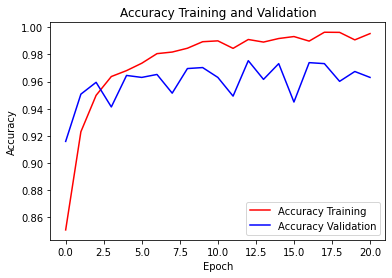

In [ ]:
plt.plot(history.history['accuracy'], 'r', label='Accuracy Training')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy Validation')
plt.title('Accuracy Training and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

In [ ]:
score = model.evaluate(valid_gen)
print(f'Accuracy Score = {round(score[1], 2) * 100}%')

44/44 [==============================] - 25s 562ms/step - loss: 0.1257 - accuracy: 0.9732
Accuracy Score = 97.0%


#### Calculate confusion matrix, precision, recall, f1

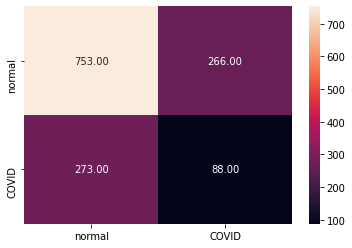

In [ ]:
y_true = valid_gen.classes
y_pred = model.predict(valid_gen)
y_pred = y_pred.reshape(-1)
y_pred = y_pred > 0.5
cf = confusion_matrix(y_true, y_pred)
sns.heatmap(cf, xticklabels=classes, yticklabels=classes, annot=True, fmt='.2f');

In [ ]:
report = classification_report(y_true, y_pred, target_names=classes)
print(report)

              precision    recall  f1-score   support

      normal       0.73      0.74      0.74      1019
       COVID       0.25      0.24      0.25       361

    accuracy                           0.61      1380
   macro avg       0.49      0.49      0.49      1380
weighted avg       0.61      0.61      0.61      1380



#### ROC-AUC curve and AUC score

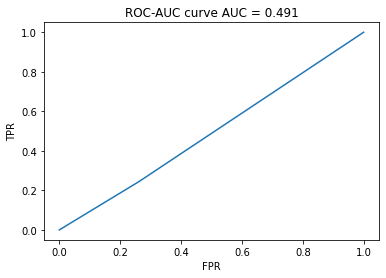

In [ ]:
fpr, tpr, thresh = roc_curve(y_true, y_pred)
auc_score = round(roc_auc_score(y_true, y_pred), 3)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f'ROC-AUC curve AUC = {auc_score}')
plt.show()

#### Calculate Accuracy, Sensitivity, specificity, and PPV
Calculate PPV (Positive Predictive Value) using Bayes Theorem
 
 
$$ PPV = \frac{sensitivity \times prevalence}{sensitivity\times prevalence + (1 - specificty)\times(1 - prevalence)} $$

In [ ]:
# tp, fp, tn, fn
tp = np.sum((y_true == 1) & (y_pred == 1))
fp = np.sum((y_true == 0) & (y_pred == 1))
tn = np.sum((y_true == 0) & (y_pred == 0))
fn = np.sum((y_true == 1) & (y_pred == 0))

# sensitivity, specificity
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Accuracy = {round(accuracy * 100, 2)}%')
print(f'Sensitivity = {round(sensitivity * 100, 2)}%')
print(f'Specificity = {round(specificity * 100, 2)}%')
    
# Calculate PPV according to Bayes Theorem
prev = np.sum(y_true) / len(y_true)
numerator = sensitivity * prev
denominator = sensitivity * prev + (1 - specificity) * (1 - prev)
ppv = numerator / denominator
print(f'Positive Predictive Value = {round(ppv * 100, 2)}%')


Accuracy = 60.94%
Sensitivity = 24.38%
Specificity = 73.9%
Positive Predictive Value = 24.86%


$$ P^4 $$ 
#### (Pretty Piss Poor Performance)

But it is a baseline, and we are getting the metrics to be used worked out.